データ読み込みとグラフ出力による確認

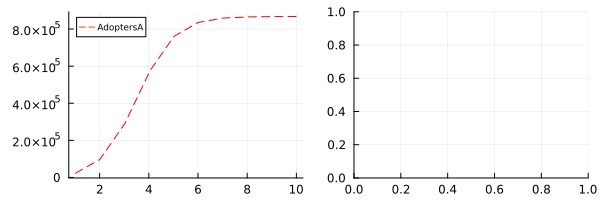

d:\Dropbox\JuliaDocs\NortonBassModel


In [19]:
using Plots
using CSV
using DataFrames 
println(pwd())
# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
#Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   # plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

Norton-Bassモデルのより進んだ最適化手法である Limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) を試す。目的関数としてハバーロス（Huber Loss）を利用する。ハバーロスは、二乗誤差と絶対誤差を組み合わせた損失関数であり、異常値の影響を受けにくい特性を持つ．

In [20]:
using Optim
using DifferentialEquations
using CSV
using DataFrames 

# Parameters
TIMESTEP = 0.015625
TMAX = 10
ContactRatec = 100
AverageProductLifel = 5
TotalPopulationN = 1e+06

# System of ODEs
function system!(du, u, p, t)
    AdoptersA, PotentialAdoptersP = u
    AdoptionFractioni, AdvertisingEffectivenessa = p
    AdoptionfromAdvertising = AdvertisingEffectivenessa * PotentialAdoptersP
    AdoptionfromWordofMouth = ContactRatec * AdoptionFractioni * PotentialAdoptersP * AdoptersA / TotalPopulationN
    AdoptionRateAR = AdoptionfromAdvertising + AdoptionfromWordofMouth
    DiscardRate = AdoptersA / AverageProductLifel

    du[1] = AdoptionRateAR - DiscardRate
    du[2] = -AdoptionRateAR + DiscardRate
end

u0 = [0, TotalPopulationN]
tspan = (0.0, TMAX)
p_initial = [0.001, 0.001]  # Adjust initial values
prob = (p) -> ODEProblem(system!, u0, tspan, p)

function load_data(filename)
    data = CSV.read(filename, DataFrame)
    t_data = data[:,1] 
    y_data = data[:,2]
    return t_data, y_data
end

# Huber loss function
function huber_loss(y_true, y_pred, δ=0.5)  # Adjust delta parameter
    return sum(abs2(x) <= δ^2 ? 0.5*x^2 : δ*(abs(x) - 0.5*δ^2) for x in (y_true - y_pred))
end

function objective(p)
    sol = solve(prob(p), Tsit5(), reltol=1e-8, abstol=1e-8)
    t_data, y_data = load_data("AdpotersAdata.csv")
    sol_interpolated = [sol(t)[1] for t in t_data]
    return huber_loss(y_data, sol_interpolated)  # Use Huber loss
end

# We use the L-BFGS algorithm and finite difference gradients
res = optimize(objective, p_initial, LBFGS(), Optim.Options(f_tol = 1e-9), autodiff = :finite)

p_optimal = Optim.minimizer(res)
println("Optimal value for AdoptionFractioni: ", p_optimal[1])
println("Optimal value for AdvertisingEffectivenessa: ", p_optimal[2])

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warn

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.405473973067143. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.409141304101124. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.115811149510762. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.1183759182277315. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.1095308469687915. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=5.113939598129479. Aborting. There is either a

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596


┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:596
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:575


┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.495585210396548e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.495626880004145e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.495612433340238e-6. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=4.495599656881543e-6. Aborting. There i

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=7.192859567419615e-5. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00014385417520639622. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00014385550860114132. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.00014385504631341426. Aborting. T

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.004598693409747389. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.004598699941971181. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.009187773087469632. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.009187858295781318. Aborting. There i

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5222686217770842. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.5222743797542788. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9456719242516087. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9458612387348987. Aborting. There is either

┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9457885339367287. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9457446106082403. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=0.9457665710471798. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589
┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=1.622509680110594. Aborting. There is either 

Optimal value for AdoptionFractioni: 0.015000093429637516
Optimal value for AdvertisingEffectivenessa: 0.010999635242264492


┌ Warning: dt(1.7763568394002505e-15) <= dtmin(1.7763568394002505e-15) at t=2.7210436272571683. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\MakotoKimura\.julia\packages\SciMLBase\VdcHg\src\integrator_interface.jl:589


最適値を用いた時間積分結果の出力

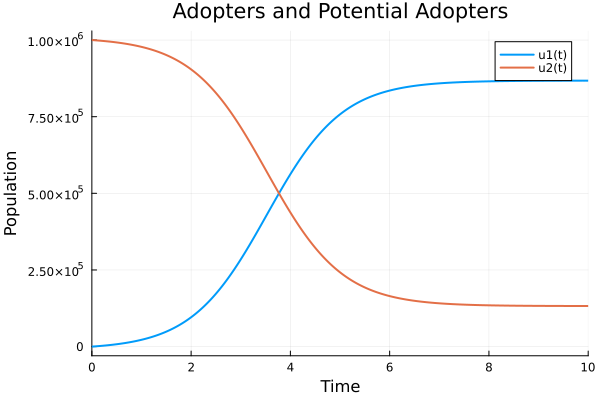

In [21]:
using Plots

# Solve the ODE problem with the optimal parameter value
sol = solve(prob(p_optimal), Tsit5(), reltol=1e-8, abstol=1e-8)

# Plot results
plot(sol, xlabel="Time", ylabel="Population", title="Adopters and Potential Adopters", lw=2)

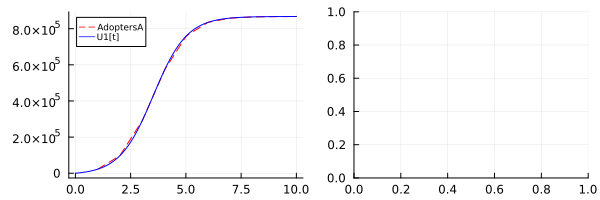

In [22]:
using Plots
using CSV
using DataFrames 

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

データフレーム用パッケージの追加

各データセットに対して決定係数(R^2)、Theilの不等式統計（Um, Us, Uc）、平均絶対誤差（MAE）、平均二乗誤差（MSE）、そして平均絶対パーセント誤差（MAPE）を計算し、結果をDataFrameに保存する。その後、DataFrameの内容を出力する。ここで、各行は特定のデータセットに対応し、各列は誤差指標に対応する。

各変数の時系列変化値を表形式で表示する

In [23]:
using Statistics
using DataFrames
using Interpolations

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")]

# Define indices for Y variables
Y_indices = [1]

# Define DataFrame for storing error metrics
error_metrics_df = DataFrame(
    DataLabel = String[], 
    NumberOfDataPoints = Int64[], # Add field for number of data points
    R2 = Float64[],  # R^2 (Coefficient of determination)
    Um = Float64[],  # Theil's inequality statistics
    Us = Float64[],
    Uc = Float64[],
    MAE = Float64[], 
    MSE = Float64[], 
    MAPE = Float64[]
)

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Record the number of data points
    num_data_points = length(t)
    # Get the range of time values for which data exists
    t_min, t_max = minimum(t), maximum(t)
    # Filter sol's time points to the range of time values for which data exists
    sol_indices = (sol.t .>= t_min) .& (sol.t .<= t_max)
    sol_t, sol_y = sol.t[sol_indices], sol[Y_indices[i],sol_indices]
    # Interpolate the numerical solution to match the time steps of the loaded data
    interp_func = LinearInterpolation(sol_t, sol_y, extrapolation_bc=Line())
    sol_y_interp = interp_func.(t)
    # Compute the errors
    errors = abs.(y - sol_y_interp)
    # Compute MAE, MSE, and MAPE
    mae = mean(errors)
    mse = mean(errors.^2)
    mape = mean(errors ./ abs.(y)) * 100
    # Compute R-squared (coefficient of determination)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- sol_y_interp).^2)
    r2 = 1 - ss_res/ss_total
    # Compute Theil's inequality statistics
    y_mean = mean(y)
    sol_y_interp_mean = mean(sol_y_interp)
    um = sqrt(sum((y - sol_y_interp).^2)) / (sqrt(sum((y.^2)) + sqrt(sum((sol_y_interp).^2))))
    us = sqrt(sum(((y .- y_mean) .- (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .- y_mean).^2))
    uc = sqrt(sum(((y .- y_mean) .+ (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .+ sol_y_interp).^2))
    
    # Check if um + us + uc is close to 1, if not adjust the values
    total = um + us + uc
    if abs(total - 1) > 1e-6
        um /= total
        us /= total
        uc /= total
    end
    
    # Append the computed error metrics to the DataFrame
    push!(error_metrics_df, (data_label, num_data_points, r2, um, us, uc, mae, mse, mape))
end

# Print the DataFrame containing R^2, Theil's inequality statistics, MAE, MSE, and MAPE values
println(error_metrics_df)
#
CSV.write("error_metrics6.csv", error_metrics_df)

1×9 DataFrame
 Row │ DataLabel  NumberOfDataPoints  R2       Um           Us           Uc        MAE      MSE      MAPE      
     │ String     Int64               Float64  Float64      Float64      Float64   Float64  Float64  Float64   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ AdoptersA                  10      1.0  0.000227652  0.000477694  0.999295   46.181  5420.09  0.0880095


"error_metrics6.csv"